In [72]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest
import os
import random

In [ ]:
def load_dataset(filename):
    data = json.load(open(filename, encoding="utf-8"))

    df = pd.json_normalize(
        data,
        record_path="raw_measurements",
        meta=["version","type","start_time","end_time","sampling_rate","weight_filter","zero_offset","expected_weight","robot_type","eoat_params"],
        errors="ignore"
    )

    # Renaming and ordering the data.

    df[["Mx","My","Fz"]] = pd.DataFrame(df.pop("force_vector").tolist(), index=df.index)

    flange = pd.DataFrame(df.pop("robot_tcp.flange").tolist(), index=df.index)
    df[["flange_tx","flange_ty","flange_tz"]] = pd.DataFrame(flange[0].tolist(), index=df.index)
    df[["flange_qw","flange_qx","flange_qy","flange_qz"]] = pd.DataFrame(flange[1].tolist(), index=df.index)

    tcp_off = pd.DataFrame(df.pop("robot_tcp.tcp_offset").tolist(), index=df.index)
    df[["tcp_tx","tcp_ty","tcp_tz"]] = pd.DataFrame(tcp_off[0].tolist(), index=df.index)
    df[["tcp_qw","tcp_qx","tcp_qy","tcp_qz"]] = pd.DataFrame(tcp_off[1].tolist(), index=df.index)

    df[["tcp_vx","tcp_vy","tcp_vz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_linear").tolist(), index=df.index)

    df[["tcp_wx","tcp_wy","tcp_wz"]] = pd.DataFrame(df.pop("robot_tcp.velocity_angular").tolist(), index=df.index)

    df[["joint_base","joint_shoulder","joint_elbow","joint_wrist_1","joint_wrist_2","joint_wrist_3"]] = (
        pd.DataFrame(df.pop("robot_tcp.joint_angles").tolist(), index=df.index)
    )

    # convert timestamps to time in milliseconds
    starting_time = df['timestamp'].min()
    df['timestamp'] = (df['timestamp'] - starting_time) * 1000
    return df

# normalizes dataframe such that expected_weight=1 and scale measurement value accordingly
def normalize_dataset_weight(df): 
    factor = 1 / df['expected_weight']
    df['expected_weight'] = df['expected_weight'] * factor
    df['value'] = df['value'] * factor

    return df

# returns average measured weight evaluated over last evaluation_time ms   
def dataset_weight_average(df, evaluation_time=500):
    df_eval = df[df['timestamp'] >= 500-evaluation_time]
    return df_eval['value'].mean()

# tests wether average weight evaluated over last evaluation_time ms is within margin % of expected_weight
def dataset_weight_average_within(df, evaluation_time=500, margin=0.05):
    avg = dataset_weight_average(df, evaluation_time=evaluation_time)
    test_margin = avg / df['expected_weight'][0]
    if (test_margin > 1 - margin) and (test_margin < 1 + margin):
        return True
    else:
        return False




In [189]:
# global test parameters
datadir = "C:/Users/ricod/Documents/force_cases_batch_1" # change folder on your own device
filelist_full = os.listdir(datadir)
SAMPLESIZE = 1000 # number of plots to generate
filelist_sample = random.sample(filelist_full, SAMPLESIZE)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


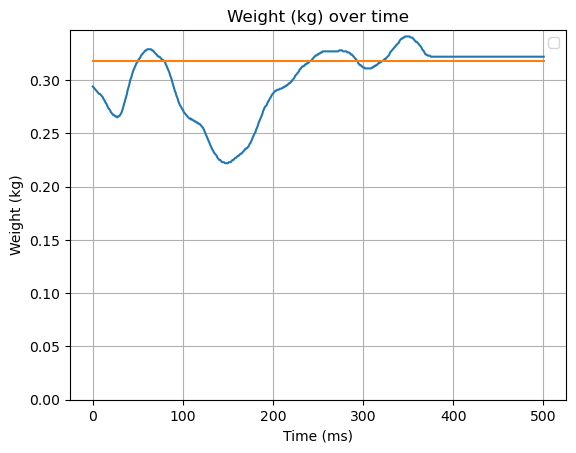

In [ ]:
# plot random SAMPLESIZE graphs seperately
def plot_weight(dataframe, expected_weight=True):
    plt.plot(dataframe['timestamp'], dataframe['value'])
    plt.xlabel("Time (ms)")
    plt.ylim(0)
    plt.ylabel("Weight (kg)")
    plt.title("Weight (kg) over time")
    plt.legend()
    plt.grid(True)
    if expected_weight:
        plt.plot(dataframe['timestamp'], dataframe['expected_weight'])
        
    plt.show()

for file in filelist_sample:
    filelist_sample
    df = load_dataset(datadir + "/" + file)
    plot_weight(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


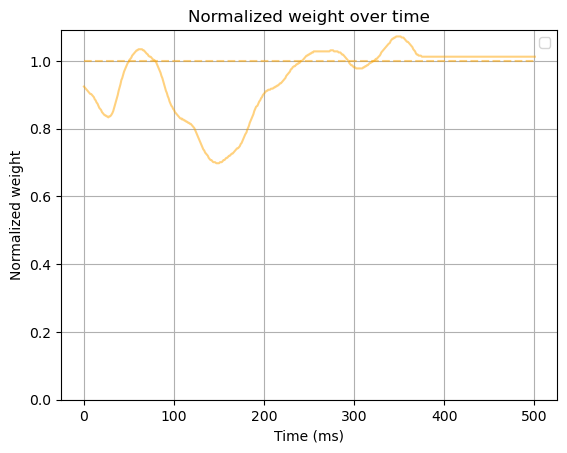

In [137]:
# plot random SAMPLESIZE graphs within same plot
def plot_weight_multiple(dataframe, expected_weight=True, normalize=True): # required list of dataframes as input
    for df in dataframe:
        c = "#"+ "%06x" % random.randint(100, 0xFFFFFF) # pick matching random color for each measurement-expected pair
        if normalize:
            df = normalize_dataset_weight(df)
            c = 'orange'

        plt.plot(df['timestamp'], df['value'], color=c, alpha=0.5)
        if expected_weight:
            plt.plot(df['timestamp'], df['expected_weight'], color=c, alpha=0.5, linestyle='--')
    
    plt.xlabel("Time (ms)")
    plt.ylim(0)
    plt.ylabel("Normalized weight")
    plt.title("Normalized weight over time")
    plt.legend()
    plt.grid(True)
    plt.show()

df_list = []
for file in filelist_sample:
    df_list.append(load_dataset(datadir + "/" + file))

plot_weight_multiple(df_list)

Dataset 0/1000 tested
Dataset 1/1000 tested
Dataset 2/1000 tested
Dataset 3/1000 tested
Dataset 4/1000 tested
Dataset 5/1000 tested
Dataset 6/1000 tested
Dataset 7/1000 tested
Dataset 8/1000 tested
Dataset 9/1000 tested
Dataset 10/1000 tested
Dataset 11/1000 tested
Dataset 12/1000 tested
Dataset 13/1000 tested
Dataset 14/1000 tested
Dataset 15/1000 tested
Dataset 16/1000 tested
Dataset 17/1000 tested
Dataset 18/1000 tested
Dataset 19/1000 tested
Dataset 20/1000 tested
Dataset 21/1000 tested
Dataset 22/1000 tested
Dataset 23/1000 tested
Dataset 24/1000 tested
Dataset 25/1000 tested
Dataset 26/1000 tested
Dataset 27/1000 tested
Dataset 28/1000 tested
Dataset 29/1000 tested
Dataset 30/1000 tested
Dataset 31/1000 tested
Dataset 32/1000 tested
Dataset 33/1000 tested
Dataset 34/1000 tested
Dataset 35/1000 tested
Dataset 36/1000 tested
Dataset 37/1000 tested
Dataset 38/1000 tested
Dataset 39/1000 tested
Dataset 40/1000 tested
Dataset 41/1000 tested
Dataset 42/1000 tested
Dataset 43/1000 teste

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


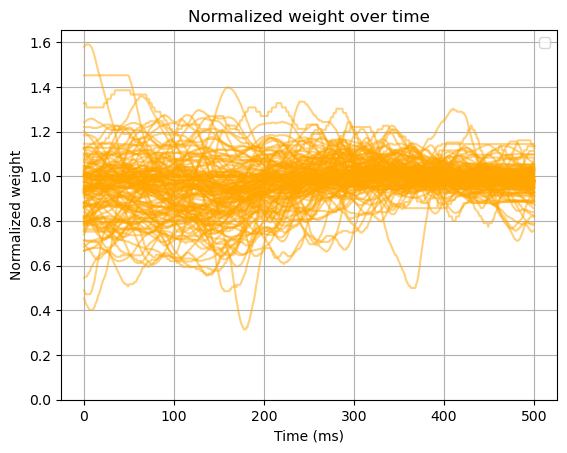

In [ ]:
# plot random SAMPLESIZE graphs within same plot but only if within margin
EVALUATION_TIME = 200 # millseconds to get average from
MARGIN = 0.05 # margin allowed to accept test

df_list = []
count = 0
for file in filelist_sample:
    df = load_dataset(datadir + "/" + file)
    if dataset_weight_average_within(df, EVALUATION_TIME, MARGIN):
        df_list.append(load_dataset(datadir + "/" + file))
    
    print(f'Dataset {count}/{SAMPLESIZE} tested')
    count = count + 1

print(f'Datasets matching criteria: {len(df_list)}')
plot_weight_multiple(df_list)